In [1]:
## STANDARD IMPORTS
import os
import time
import h5py
import numpy as np
import numpy.ma as ma
import pandas as pd
import json

# analysis
import scipy.stats
from scipy.optimize import curve_fit

# data handling
!pip3 install ../h5flow
import h5flow
from h5flow.data import dereference

## 3D PLOTTING
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm

Defaulting to user installation because normal site-packages is not writeable
Processing /global/u1/j/jvmead/dune/h5flow
  Preparing metadata (setup.py) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31486 sha256=cffaf28ce6dd3aee452d2251be1db5ad629a6f271658d616fcf3db1954a5fc71
  Stored in directory: /tmp/pip-ephem-wheel-cache-ccx2_iya/wheels/0c/cb/86/6b657de7e9cca14c751cd866f4b2a2bfe75dd32620aa8569ce
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


In [3]:
dirname = 'mc_processed_MiniRun5_1E19_RHC.flow.0000000.FLOW_TrapType_evts_all'
spes_filename = dirname+'/spes_evt.npz'
noise_filename = dirname+'/noise_evt.npz'
config_filename = dirname+'/config.json'
hits_filename = dirname+'/hits_evt.npz'
hits_config_filename = dirname+'/hits_config.json'
true_hits_filename = dirname+'/true_nu_int.csv'

# check if true hits file exists
if os.path.exists(true_hits_filename):
    true_hits = pd.read_csv(true_hits_filename)
    print(true_hits.head())

# print configuration and hit configuration
with open(config_filename) as json_file:
    config = json.load(json_file)
    print(json.dumps(config, indent=4))
with open(hits_config_filename) as json_file:
    hits_config = json.load(json_file)
    print(json.dumps(hits_config, indent=4))

   file_idx  event_id  vertex_id    start_time  start_time_idx  tpc_num
0       0.0       0.0        6.0  1.200006e+06      479.237081      0.0
1       0.0       0.0        6.0  1.200006e+06      480.494348      1.0
2       0.0       0.0        6.0  1.200006e+06      480.494902      2.0
3       0.0       0.0        6.0  1.200006e+06      479.234332      3.0
4       0.0       0.0        6.0  1.200006e+06      479.247284      4.0
{
    "timestamp": "2025-02-25 04:43:23.909363",
    "filename": "/global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta2a/FLOW/0000000/MiniRun5_1E19_RHC.flow.0000000.FLOW.hdf5",
    "is_data": false,
    "save_truth": true,
    "summed": "TrapType",
    "max_evts": null,
    "calib_filename": "calibration/mc_calib.csv",
    "geom_filename": "geom_files/light_module_desc-4.0.0.csv",
    "channel_status_filename": "channel_status/channel_status.csv",
    "maskfile": "channel_sum_masks/TrapType_masks_MC.npz"
}
{
  

In [4]:
import scipy.stats

def clopper_pearson_interval(k, n, alpha=0.6827):
    alpha = 1 - alpha
    lo = scipy.stats.beta.ppf(alpha / 2, k, n - k + 1) if k > 0 else 0.0
    hi = scipy.stats.beta.ppf(1 - alpha / 2, k + 1, n - k) if k < n else 1.0
    return lo, hi


# gaussian fit func
def gaussian(x, A, mu, sig):
    return A * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [5]:
# load true hits
true_hits = pd.read_csv(true_hits_filename)
true_hit_idxs = true_hits['start_time_idx'].values

# load ticks histogram of all hits
hits_file = np.load(hits_filename)
hits_arr = hits_file['arr_0']
flat_hits = np.sum(hits_arr, axis=(0,1))

In [6]:
tolerance = 6

# info by trap type (ArClight)
acl_rec_true_hits = 0
acl_true_hits = 0
acl_rec_hits = 0
acl_delta_t = []

# info by trap type (LCM)
lcm_rec_true_hits = 0
lcm_true_hits = 0
lcm_rec_hits = 0
lcm_delta_t = []

# loop over events
for i_evt_lrs in range(hits_arr.shape[0]):

    # loop over traps
    for i_trap in range(hits_arr.shape[1]):
        is_acl = i_trap % 2 == 0
        i_tpc = i_trap // 2

        hits = np.where(hits_arr[i_evt_lrs, i_trap])[0]
        true_hit_idxs_tpc = true_hits[(true_hits['event_id'] == i_evt_lrs) & (true_hits['tpc_num'] == i_tpc)]['start_time_idx'].values

        # ACLs
        if is_acl:

            # add true hits
            acl_true_hits += len(true_hit_idxs_tpc)

            # add rec hits
            for i_hit in hits:
                acl_rec_hits += 1

                # check if true hit is within tolerance in this specific tpc

                # get true hit indices within tolerance of this hit
                delta_ts = (i_hit - true_hit_idxs_tpc)
                delta_ts = delta_ts[(delta_ts < tolerance) & (delta_ts > 0)]
                if delta_ts.size > 0:
                    delta_ts = min(delta_ts)
                    acl_delta_t.append(delta_ts)

                    # add to true rec hits
                    acl_rec_true_hits += 1

        else:

            # add true hits
            lcm_true_hits += len(true_hit_idxs_tpc)

            # add rec hits
            for i_hit in hits:
                lcm_rec_hits += 1

                # get true hit indices within tolerance of this hit
                delta_ts = (i_hit - true_hit_idxs_tpc)
                delta_ts = delta_ts[(delta_ts < tolerance) & (delta_ts > 0)]
                if delta_ts.size > 0:
                    delta_ts = min(delta_ts)
                    lcm_delta_t.append(delta_ts)

                    # add to true rec hits
                    lcm_rec_true_hits += 1



# caluclate efficiency +/- clopper pearson
print(f'ACL True Hits: {acl_true_hits}')
print(f'ACL Rec Hits: {acl_rec_hits}')
print(f'ACL Rec True Hits: {acl_rec_true_hits}')

print(f'LCM True Hits: {lcm_true_hits}')
print(f'LCM Rec Hits: {lcm_rec_hits}')
print(f'LCM Rec True Hits: {lcm_rec_true_hits}')

# ACL efficiency
acl_eff = acl_rec_true_hits / acl_true_hits
acl_eff_err = clopper_pearson_interval(acl_rec_true_hits, acl_true_hits)
print(f'ACL Efficiency: {acl_eff:.2f} + {acl_eff_err[1] - acl_eff:.2f} - {acl_eff - acl_eff_err[0]:.2f}')
# ACL fake rate
acl_fake_rate = 1 - (acl_rec_true_hits / acl_rec_hits)
acl_fake_rate_err = clopper_pearson_interval(acl_rec_true_hits, acl_rec_hits)
print(f'ACL Fake Rate: {acl_fake_rate:.2f} + {1 - acl_fake_rate_err[0] - acl_fake_rate:.2f} - {1 - acl_fake_rate_err[1] - acl_fake_rate:.2f}')

# LCM efficiency
lcm_eff = lcm_rec_true_hits / lcm_true_hits
lcm_eff_err = clopper_pearson_interval(lcm_rec_true_hits, lcm_true_hits)
print(f'LCM Efficiency: {lcm_eff:.2f} + {lcm_eff_err[1] - lcm_eff:.2f} - {lcm_eff - lcm_eff_err[0]:.2f}')

# LCM fake rate
lcm_fake_rate = 1 - (lcm_rec_true_hits / lcm_rec_hits)
lcm_fake_rate_err = clopper_pearson_interval(lcm_rec_true_hits, lcm_rec_hits)
print(f'LCM Fake Rate: {lcm_fake_rate:.2f} + {1 - lcm_fake_rate_err[0] - lcm_fake_rate:.2f} - {1 - lcm_fake_rate_err[1] - lcm_fake_rate:.2f}')


ACL True Hits: 1059
ACL Rec Hits: 829
ACL Rec True Hits: 690
LCM True Hits: 1059
LCM Rec Hits: 1227
LCM Rec True Hits: 915
ACL Efficiency: 0.65 + 0.01 - 0.02
ACL Fake Rate: 0.17 + 0.01 - -0.01
LCM Efficiency: 0.86 + 0.01 - 0.01
LCM Fake Rate: 0.25 + 0.01 - -0.01


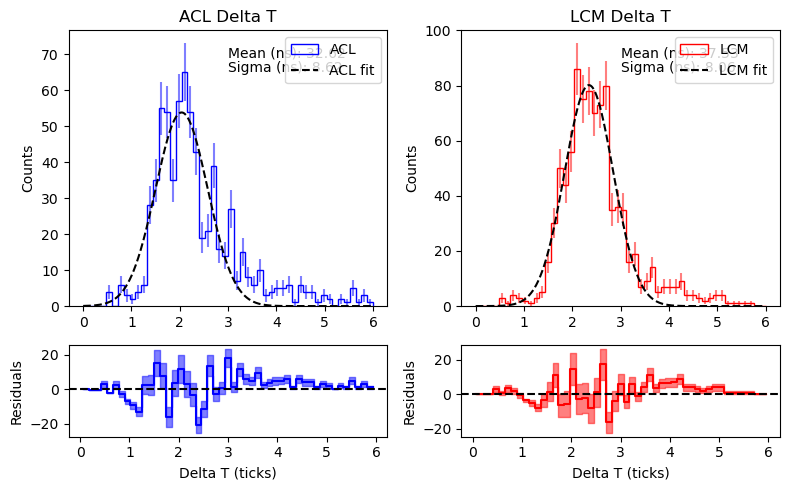

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Gaussian function
def gaussian(x, A, mu, sig):
    return A * np.exp(-0.5 * ((x - mu) / sig) ** 2)

# Set up figure with GridSpec
fig, ax = plt.subplots(2, 2, figsize=(8, 5), gridspec_kw={'height_ratios': [3, 1]})
nbins = 50
tolerance = 6
interp_bin_centres = np.linspace(0, tolerance, 1000)

# Function to fit and plot
def plot_histogram_and_fit(ax_main, ax_resid, delta_t, color, label):
    # Histogram
    ax_main.hist(delta_t, bins=nbins, range=(0, tolerance), histtype='step', color=color, label=label)

    # Bin calculations
    hist, bin_edges = np.histogram(delta_t, bins=nbins, range=(0, tolerance))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    sqrtN = np.sqrt(hist)

    # Error bars
    ax_main.errorbar(bin_centers, hist, yerr=sqrtN, fmt='none', color=color, alpha=0.5)

    # Fit Gaussian
    param_bounds = ([0, np.min(bin_centers), 0.01], [np.inf, np.max(bin_centers), np.std(delta_t)])
    popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[max(hist), np.mean(delta_t), np.std(delta_t)], bounds=param_bounds, maxfev=10000)

    # Plot fit
    ax_main.plot(interp_bin_centres, gaussian(interp_bin_centres, *popt), color='k', linestyle='--', label=f'{label} fit')

    # Labels
    #ax_main.set_xlabel('Delta T (ticks)')
    ax_main.set_ylabel('Counts')
    ax_main.set_title(f'{label} Delta T')
    ax_main.text(0.5, 0.9, f'Mean (ns): {popt[1]*16:.2f}', transform=ax_main.transAxes)
    ax_main.text(0.5, 0.85, f'Sigma (ns): {popt[2]*16:.2f}', transform=ax_main.transAxes)
    ax_main.legend()

    # Residuals
    resids = hist - gaussian(bin_centers, *popt)
    ax_resid.step(bin_centers, resids, color=color)
    ax_resid.fill_between(bin_centers, resids-sqrtN, resids+sqrtN, color=color, alpha=0.5, step='pre')
    ax_resid.axhline(0, color='k', linestyle='--')
    ax_resid.set_xlabel('Delta T (ticks)')
    ax_resid.set_ylabel('Residuals')

# Plot ACL
plot_histogram_and_fit(ax[0, 0], ax[1, 0], acl_delta_t, 'b', 'ACL')

# Plot LCM
plot_histogram_and_fit(ax[0, 1], ax[1, 1], lcm_delta_t, 'r', 'LCM')

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
def plot_waveform(i_evt_lrs, time_bins, wvfm, hit_where, i_mask, true_hits, logy=False):

  fig = plt.figure(figsize=(12, 3))
  # set a title
  fig.suptitle(f'Event {i_evt_lrs}, TPC {i_mask[0] // 2}')

  if logy==False:
  # Linear plot
    # acls
    plt.plot(time_bins, wvfm[0], label='ACL', color='red', alpha=0.5)
    plt.plot(hit_where[0] * 16/1000, wvfm[0][hit_where[0]], 'x', color='red')
    # lcms
    plt.plot(time_bins, wvfm[1], label='LCMS', color='blue', alpha=0.5)
    plt.plot(hit_where[1] * 16/1000, wvfm[1][hit_where[1]], 'x', color='blue')
    # baseline
    plt.axhline(0, color='k', linestyle=':', alpha=0.5)
    # true hits
    for hit_idx in true_hits:
      plt.axvline(hit_idx * 16/1000, color='purple', linestyle=':', alpha=0.5, label='True hits')
    plt.xlabel('Time (us)')
    plt.ylabel('SPEs')
    plt.legend()

  else:
  # Logarithmic plot
    # acls
    plt.plot(time_bins, wvfm[0] + 1, label='ACL', color='red', alpha=0.5)
    plt.plot(hit_where[0] * 16/1000, wvfm[0][hit_where[0]] + 1, 'x', color='red')
    # lcms
    plt.plot(time_bins, wvfm[1] + 1, label='LCMS', color='blue', alpha=0.5)
    plt.plot(hit_where[1] * 16/1000, wvfm[1][hit_where[1]] + 1, 'x', color='blue')
    # baseline
    plt.axhline(1, color='k', linestyle=':', alpha=0.5)
    # true hits
    for hit_idx in true_hits:
      plt.axvline(hit_idx * 16/1000, color='purple', linestyle=':', alpha=0.5)
    plt.yscale('log')
    plt.xlabel('Time (us)')

  plt.tight_layout()
  plt.show()

In [9]:
from scipy.ndimage import uniform_filter1d

# load hit finder config
with open(hits_config_filename) as json_file:
    hits_config = json.load(json_file)
n_noise_factor = hits_config['n_noise_factor']
n_bins_rolled = hits_config['n_bins_rolled']
n_sqrt_rt_factor = hits_config['n_sqrt_rt_factor']
pe_weight = hits_config['pe_weight']

# loading events
time_bins = np.linspace(0, 16, 1000)

# wvfms
summed_wvfms_file = np.load(spes_filename)
summed_wvfms = np.array(summed_wvfms_file['arr_0'])

# noise thresholds
heights_file = np.load(noise_filename)
heights = np.array(heights_file['arr_0'])

# loading hits
hits_file = np.load(hits_filename)
hits = np.array(hits_file['arr_0'])

# loading true hits
true_hits = pd.read_csv(true_hits_filename)

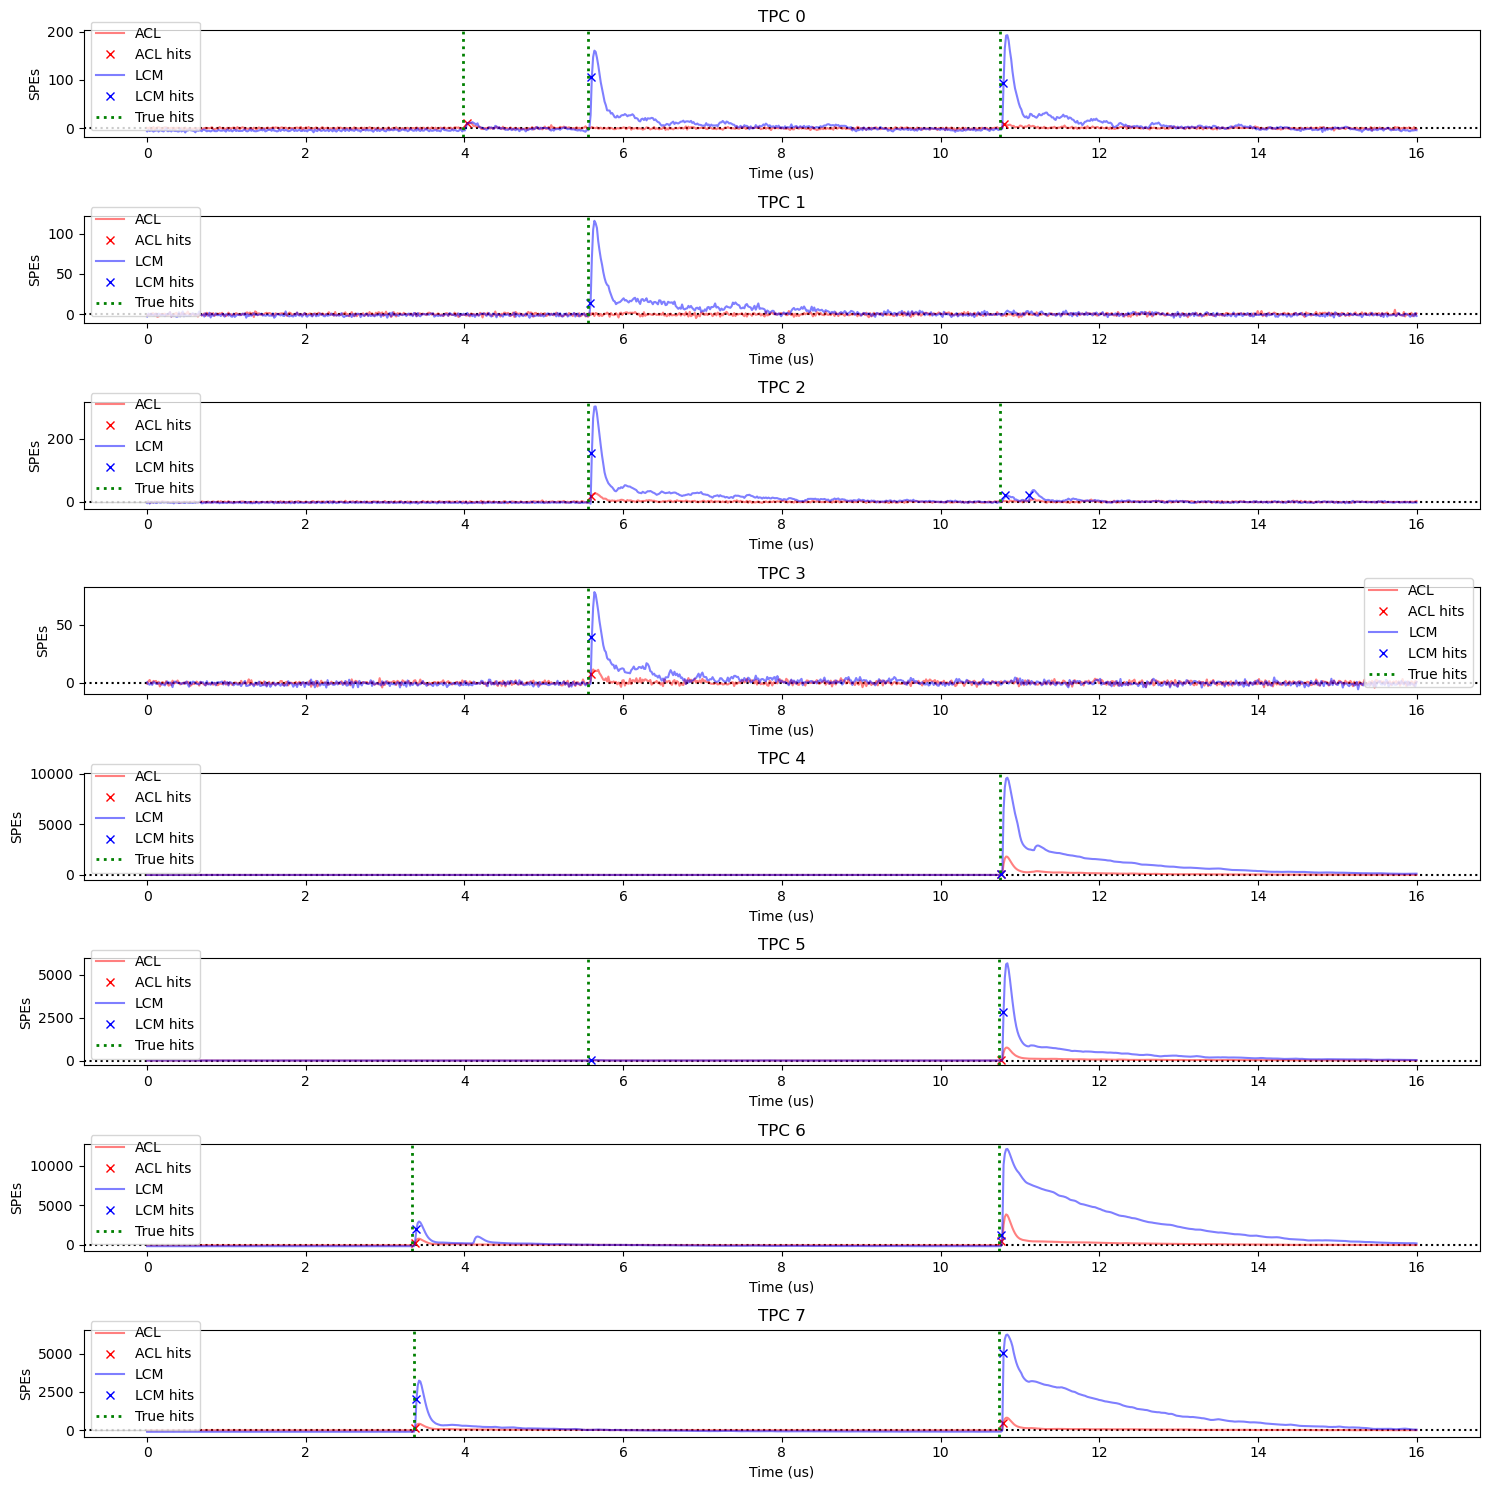

In [10]:
# plotting script to plot the summed traptype waveforms per tpc with interactions
def plot_summed_trap_waveform_per_tpc_with_interactions(i_evt, time_bins, summed_wvfms, hits, true_hits):

  # 2x2 TPC subplot grid, each with traptype sum waveforms
  fig, axs = plt.subplots(8, 1, figsize=(15, 15))

  for tpc in range(8):
    acl_mask = 2*tpc
    lcm_mask = 2*tpc + 1

    axs[tpc].axhline(0, color='k', linestyle=':')

    # get wvfm, threshold, and hits for the event
    acl_wvfm = summed_wvfms[i_evt, acl_mask]
    acl_hit = hits[i_evt, acl_mask]
    acl_hit_where = np.where(acl_hit)[0]

    lcm_wvfm = summed_wvfms[i_evt, lcm_mask]
    lcm_hit = hits[i_evt, lcm_mask]
    lcm_hit_where = np.where(lcm_hit)[0]

    axs[tpc].plot(time_bins, acl_wvfm, label='ACL', color='red', alpha=0.5)
    axs[tpc].plot(acl_hit_where * 16/1000, acl_wvfm[acl_hit_where], 'x', color='red', label='ACL hits')

    axs[tpc].plot(time_bins, lcm_wvfm, label='LCM', color='blue', alpha=0.5)
    axs[tpc].plot(lcm_hit_where * 16/1000, lcm_wvfm[lcm_hit_where], 'x', color='blue', label='LCM hits')

    # true hits
    true_hits_tpc_evt = true_hits[(true_hits['event_id'] == i_evt) & (true_hits['tpc_num'] == tpc)]['start_time_idx'].values
    true_hits_idx = np.array(true_hits_tpc_evt)
    for hit_idx in true_hits_idx:
      label = 'True hits' if hit_idx == true_hits_idx[0] else None
      axs[tpc].axvline(hit_idx * 16/1000, color='green', linestyle=':', linewidth=2, label=label)

    axs[tpc].set_xlabel('Time (us)')
    axs[tpc].set_ylabel('SPEs')
    axs[tpc].set_title(f'TPC {tpc}')

    # legend
    axs[tpc].legend()

  plt.tight_layout()
  plt.show()


# plot summed traptype waveforms per tpc with interactions
i_evt_lrs = 25
plot_summed_trap_waveform_per_tpc_with_interactions(i_evt_lrs, time_bins, summed_wvfms, hits, true_hits)

In [11]:
def plot_all_tpc_waveform(wvfms, time_bins, hit_where, i_evt_lrs, i_mask, true_hits=None):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
  # set a title
  fig.suptitle(f'Event {i_evt_lrs}, TrapType {i_mask % 2}')

  # Linear plot
  for i,wvfm in enumerate(wvfms):
    ax1.plot(time_bins, wvfm, label=f'TPC {i}')
    label = 'Rec hits' if i == 0 else None
    ax1.plot(hit_where[i] * 16/1000, wvfm[hit_where[i]], 'x', color='k', label=label)
  for hit_idx in true_hits:
    label = 'True hits' if i == 0 else None
    ax1.axvline(hit_idx * 16/1000, color='purple', linestyle=':', alpha=0.5, label=label)
  ax1.axhline(0, color='k', linestyle=':', alpha=0.5)
  ax1.set_xlabel('Time (us)')
  ax1.set_ylabel('SPEs')
  ax1.legend()

  # Logarithmic plot
  for i,wvfm in enumerate(wvfms):
    ax2.plot(time_bins, wvfm + 1, label=f'TPC {i}')
    label = 'Rec hits' if i == 0 else None
    ax2.plot(hit_where[i] * 16/1000, wvfm[hit_where[i]] + 1, 'x', color='k', label=label)
  for hit_idx in true_hits:
    label = 'True hits' if i == 0 else None
    ax2.axvline(hit_idx * 16/1000, color='purple', linestyle=':', alpha=0.5, label=label)
  ax2.axhline(1, color='k', linestyle=':', alpha=0.5)
  ax2.set_yscale('log')
  ax2.set_xlabel('Time (us)')
  #ax2.set_ylim(0.1, wvfm.max()*1.1)

  plt.tight_layout()
  plt.show()

In [12]:
true_times = []
rec_times = []
true_incl_times = []

for i_evt_lrs in light_wvfm_ref: #[:10]:

    wvfms = []
    hits_where = []
    true_hits_where = []
    true_hits_incl_where = []

    # find the corresponding spill_id for light wvfm ref = i_evt_lrs
    #print(f'light wvfm ref {i_evt_lrs}')
    index = np.where(light_wvfm_ref==i_evt_lrs)[0][0]
    #print(index)
    spill_id_lwr = spill_id[index]
    true_hits_evt = true_hits[(true_hits['event_id'] == spill_id_lwr) & (true_hits['tpc_num'] > -1)]
    if len(true_hits_evt) == 0:
        continue

    for i_tpc in range(0, 4):
        #print(f'Event {i_evt_lrs} has spill_id {spill_id_lwr}')
        true_hits_tpc = true_hits[(true_hits['tpc_num'] == i_tpc) & (true_hits['event_id'] == spill_id_lwr)]
        #true_hits_tpc = true_hits[(true_hits['event_id'] == spill_id_lwr)]
        true_hits_idx = true_hits_tpc['start_time_idx'].values + 100
        if len(true_hits_idx) == 0:
            continue

        i_mask = 2*i_tpc + 1 # 2 * TPC + TrapType
        wvfm = summed_wvfms[i_evt_lrs,i_mask]
        median = np.median(wvfm)
        mad = np.median(np.abs(wvfm - median))
        mad_threshold = 5*mad
        wvfm_rolled = np.roll(wvfm, n_bins_rolled)
        rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
        sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
        dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
        height = heights[i_evt_lrs,i_mask]

        hit = hits[i_evt_lrs,i_mask]
        hit_where = np.where(hit)[0]

        wvfms.append(wvfm)
        hits_where.append(hit_where)
        true_hits_where.append(true_hits_idx)

    true_hits_tpc = true_hits[(true_hits['tpc_num'] == -1) & (true_hits['event_id'] == spill_id_lwr)]
    #true_hits_tpc = true_hits[(true_hits['event_id'] == spill_id_lwr)]
    true_hits_idx = true_hits_tpc['start_time_idx'].values + 100
    if len(true_hits_idx) == 0:
        continue
    true_hits_incl_where.append(true_hits_idx)

    #print(hits_where)
    #print(true_hits_where)

    true_times.append(true_hits_where)
    rec_times.append(hits_where)
    true_incl_times.append(true_hits_incl_where)

    if i_evt_lrs == 0:
        plot_all_tpc_waveform(wvfms, time_bins, hits_where, i_evt_lrs, i_mask, true_hits_where)

NameError: name 'light_wvfm_ref' is not defined

In [ ]:
true_times_list = []
rec_times_list = []

for i in range(len(true_times)):
    for j in range(len(true_times[i][0])):
      true_times_list.append(true_times[i][0][j])
    for j in range(len(rec_times[i][0])):
      rec_times_list.append(rec_times[i][0][j])

true_times_flat = np.array(true_times_list)
rec_times_flat = np.array(rec_times_list)

# for every combination of true and rec times , calculate the residuals
residuals = []
true = 0
rec_true = 0
rec = 0
#true_ext = 0
for i in range(len(true_times)):
    for j in range(len(rec_times[i][0])):
        rec+=1
    for j in range(len(true_times[i][0])):
        true+=1
    #for j in range(len(true_incl_times)):
    #    true_ext+=1
        for k in range(len(rec_times[i][0])):
            # conditions
            time_diff = rec_times[i][0][k] - true_times[i][0][j] < 6
            time_ord = rec_times[i][0][k] - true_times[i][0][j] > 0
            if time_diff and time_ord:
                # check if hit lies between pair
                residuals.append(true_times[i][0][j] - rec_times[i][0][k])
                rec_true+=1
            '''
            # for external to tpcs
            time_diff = rec_times[i][0][k] - true_incl_times[j][0] < 6
            time_ord = rec_times[i][0][k] - true_incl_times[j][0] > 0
            if time_diff and time_ord:
                # check if hit lies between pair
                residuals.append(true_incl_times[j][0] - rec_times[i][0][k])
                rec_true+=1
            '''


efficiency = rec_true/true
d_efficiency = clopper_pearson_interval(rec_true, true)

fake_tate = 1 - rec_true/rec
d_fake_rate = clopper_pearson_interval(rec_true, rec)

#eff_incl =

bins = np.linspace(0, 1001, 1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(true_times_flat, bins=bins, histtype='step', label='True hits', alpha=0.5)
ax.hist(rec_times_flat, bins=bins, histtype='step', label='Hit finder', alpha=0.5)
text = f'Efficiency: {efficiency:.2f} +{d_efficiency[1] - efficiency:.2f}, -{efficiency - d_efficiency[0]:.2f}'
text += f'\nFake Rate: {fake_tate:.2f} +{d_fake_rate[1] - fake_tate:.2f}, -{fake_tate - d_fake_rate[0]:.2f}'
ax.text(0.5, 0.5, text, transform=ax.transAxes)
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.show()

In [ ]:
residuals = np.array(residuals)
# gausssian fit
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
from scipy.optimize import curve_fit

# fit the residuals
bins = np.linspace(-100, 100, 201)
hist, bin_edges = np.histogram(residuals, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# integral of histogram between -5 and 0
integral = np.sum(hist[np.where((bin_centers > -5) & (bin_centers < 0))])
print(f'Integral between -5 and 0 = {integral}')
# set upper and lower bounds for the fit parameter 0 based on integral+-sqrt(integral)
p0 = [integral, -1, 1]
l_lower = integral - np.sqrt(integral)
l_upper = integral + np.sqrt(integral)
bounds = ([l_lower, -10, 0], [l_upper, 0, 10])
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[integral, -1, 1], bounds=bounds)
new_bin_centers = np.linspace(bin_centers[0], bin_centers[-1], 2001)

# plot the residuals
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(residuals, bins=bins, histtype='step', label='Residuals', alpha=0.5)
ax.plot(new_bin_centers, gaussian(new_bin_centers, *popt), label='Gaussian fit')
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.show()

# plot the residuals with a zoom
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(residuals, bins=bins, histtype='step', label='Residuals', alpha=0.5)
ax.plot(new_bin_centers, gaussian(new_bin_centers, *popt), label='Gaussian fit')
# print text of mean of gaussian
text = f'Mean = {popt[1]:.2f} ns'
ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')
# print text of width of gaussian in ns
text = f'Width = {popt[2]*16:.2f} ns'
ax.text(0.05, 0.85, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.tight_layout()
plt.xlim(-10, 10)
plt.show()

In [ ]:
true_times = []
rec_times = []

for i_evt_lrs in light_wvfm_ref[:20]:

    wvfms = []
    hits_where = []
    true_hits_where = []

    # find the corresponding spill_id for light wvfm ref = i_evt_lrs
    #print(f'light wvfm ref {i_evt_lrs}')
    index = np.where(light_wvfm_ref==i_evt_lrs)[0][0]
    #print(index)
    spill_id_lwr = spill_id[index]
    true_hits_evt = true_hits[(true_hits['event_id'] == spill_id_lwr)]# & (true_hits['tpc_num'] > -1)]
    if len(true_hits_evt) == 0:
        continue
    true_hits_idx = true_hits_evt['start_time_idx'].values + 100

    for i_tpc in range(0, 4):
        #print(f'Event {i_evt_lrs} has spill_id {spill_id_lwr}')
        #true_hits_tpc = true_hits[(true_hits['tpc_num'] == i_tpc) & (true_hits['event_id'] == spill_id_lwr)]
        #true_hits_tpc = true_hits[(true_hits['event_id'] == spill_id_lwr)]
        #true_hits_idx = true_hits_tpc['start_time_idx'].values
        #if len(true_hits_idx) == 0:
        #    continue

        i_mask = 2*i_tpc + 1 # 2 * TPC + TrapType
        wvfm = summed_wvfms[i_evt_lrs,i_mask]
        median = np.median(wvfm)
        mad = np.median(np.abs(wvfm - median))
        mad_threshold = 5*mad
        wvfm_rolled = np.roll(wvfm, n_bins_rolled)
        rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
        sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
        dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
        height = heights[i_evt_lrs,i_mask]

        hit = hits[i_evt_lrs,i_mask]
        hit_where = np.where(hit)[0]

        wvfms.append(wvfm)
        hits_where.append(hit_where)
    true_hits_where.append(true_hits_idx)

    #print(hits_where)
    #print(true_hits_where)

    true_times.append(true_hits_where)
    rec_times.append(hits_where)

    if i_evt_lrs == 0:
        plot_all_tpc_waveform(wvfms, time_bins, hits_where, i_evt_lrs, i_mask, true_hits_idx)

In [ ]:
for i in range(len(true_times)):
    for j in range(len(true_times[i][0])):
      true_times_list.append(true_times[i][0][j])
    for j in range(len(rec_times[i][0])):
      rec_times_list.append(rec_times[i][0][j])

true_times_flat = np.array(true_times_list)
rec_times_flat = np.array(rec_times_list)

# for every combination of true and rec times , calculate the residuals
residuals = []
true = 0
rec_true = 0
rec = 0
for i in range(len(true_times)):
    for j in range(len(rec_times[i][0])):
        rec+=1
    for j in range(len(true_times[i][0])):
        true+=1
        for k in range(len(rec_times[i][0])):
            # conditions
            time_diff = rec_times[i][0][k] - true_times[i][0][j] < 6
            time_ord = rec_times[i][0][k] - true_times[i][0][j] > 0
            if time_diff and time_ord:
                # check if hit lies between pair
                residuals.append(true_times[i][0][j] - rec_times[i][0][k])
                rec_true+=1

efficiency = rec_true/true
d_efficiency = clopper_pearson_interval(rec_true, true)

fake_tate = 1 - rec_true/rec
d_fake_rate = clopper_pearson_interval(rec_true, rec)

bins = np.linspace(0, 1001, 1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(true_times_flat, bins=bins, histtype='step', label='True hits', alpha=0.5)
ax.hist(rec_times_flat, bins=bins, histtype='step', label='Hit finder', alpha=0.5)
text = f'Efficiency: {efficiency:.2f} +{d_efficiency[1] - efficiency:.2f}, -{efficiency - d_efficiency[0]:.2f}'
text += f'\nFake Rate: {fake_tate:.2f} +{d_fake_rate[1] - fake_tate:.2f}, -{fake_tate - d_fake_rate[0]:.2f}'
ax.text(0.5, 0.5, text, transform=ax.transAxes)
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.show()

In [ ]:
residuals = np.array(residuals)
# gausssian fit
def gaussian(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
from scipy.optimize import curve_fit

# fit the residuals
bins = np.linspace(-100, 100, 201)
hist, bin_edges = np.histogram(residuals, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# integral of histogram between -5 and 0
integral = np.sum(hist[np.where((bin_centers > -5) & (bin_centers < 0))])
print(f'Integral between -5 and 0 = {integral}')
# set upper and lower bounds for the fit parameter 0 based on integral+-sqrt(integral)
p0 = [integral, -1, 1]
l_lower = integral - np.sqrt(integral)
l_upper = integral + np.sqrt(integral)
bounds = ([l_lower, -10, 0], [l_upper, 0, 10])
popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=[integral, -1, 1], bounds=bounds)
new_bin_centers = np.linspace(bin_centers[0], bin_centers[-1], 2001)

# plot the residuals
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(residuals, bins=bins, histtype='step', label='Residuals', alpha=0.5)
ax.plot(new_bin_centers, gaussian(new_bin_centers, *popt), label='Gaussian fit')
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.show()

# plot the residuals with a zoom
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(residuals, bins=bins, histtype='step', label='Residuals', alpha=0.5)
ax.plot(new_bin_centers, gaussian(new_bin_centers, *popt), label='Gaussian fit')
# print text of mean of gaussian
text = f'Mean = {popt[1]:.2f} ns'
ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')
# print text of width of gaussian in ns
text = f'Width = {popt[2]*16:.2f} ns'
ax.text(0.05, 0.85, text, transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_xlabel('Ticks')
ax.set_ylabel('Hits')
ax.legend()
plt.tight_layout()
plt.xlim(-10, 10)
plt.show()

In [ ]:
# plot the waveform of the trap with the highest wvfm in the event
for i_evt_lrs in range(5):#summed_wvfms.shape[0]):

  # skip events with no hits
  all_traps = summed_wvfms[i_evt_lrs]
  all_heights = heights[i_evt_lrs]
  all_hits = hits[i_evt_lrs]

  # mask with the most hits
  i_mask = np.argmax(all_hits.sum(axis=1))

  # get wvfm, threshold, and hits for the event
  wvfm = summed_wvfms[i_evt_lrs,i_mask]
  median = np.median(wvfm)
  mad = np.median(np.abs(wvfm - median))
  mad_threshold = 5*mad
  wvfm_rolled = np.roll(wvfm, n_bins_rolled)
  rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
  sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
  dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
  height = heights[i_evt_lrs,i_mask]

  hit = hits[i_evt_lrs,i_mask]
  hit_where = np.where(hit)[0]

  if len(hit_where) < 1:
    continue

  # find the corresponding spill_id for light wvfm ref = i_evt_lrs
  index = np.where(light_wvfm_ref==i_evt_lrs)[0][0]
  spill_id_lwr = spill_id[index]

  # print event number, spill_id, and light wvfm ref etc
  print(f'Event {i_evt_lrs} has spill_id {spill_id_lwr}, and light wvfm ref {light_wvfm_ref[index]}, and spill id {spill_id_lwr}')

  # get true hits for the event
  true_hits_evt = true_hits[(true_hits['event_id'] == spill_id_lwr)]
  true_hits_idx = true_hits_evt['start_time_idx'].values + 100

  plot_waveform(wvfm, time_bins, height, mad, 5.0, dynamic_threshold, hit_where, n_noise_factor, i_evt_lrs, i_mask, true_hits_idx)
  #break